### Using PYMC

[-0.42793441  1.71757993] [0.00173192 0.00462149]
        2
0.1611 x - 1.209 x + 2.629


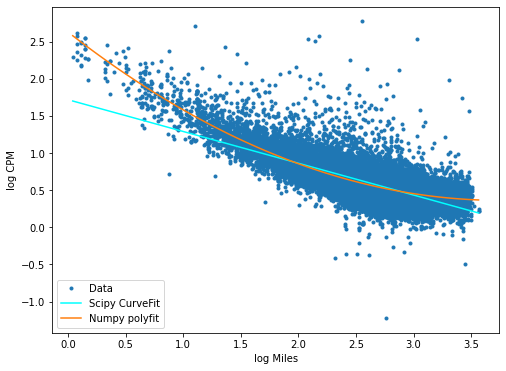

In [0]:
# Use scipy curvefit to fit the line

# Define the linear function
def linear_func(x, a, b):
    return a * x + b

# data
np.random.seed(0)
x_data = df["log Miles"].values
y_data = df["log CPM"].values

# Fit the linear function to the data
params, covariance = curve_fit(linear_func, x_data, y_data, sigma=0.1*np.ones_like(y_data))
perr = np.sqrt(np.diag(covariance))
print(params, perr)

# Extract the fitted parameters
a_fit, b_fit = params

# Create the fitted line
x_fit = np.linspace(np.min(x_data), np.max(x_data), 100)
y_fit = linear_func(x_fit, a_fit, b_fit)

# Using polyfit to fit
z = np.polyfit(x_data, y_data, 2)
p = np.poly1d(z)
print(p)

# Plot the original data and the fitted line
plt.figure(figsize=(8,6))
plt.plot(x_data, y_data, '.', label='Data')
plt.plot(x_fit, y_fit, color='cyan', label='Scipy CurveFit')
plt.plot(x_fit, p(x_fit), label="Numpy polyfit")
plt.xlabel('log Miles')
plt.ylabel('log CPM')
plt.legend()
plt.show()


In [0]:
import pymc as pm
with pm.Model() as regression_model:
	# data
 
	x1 = pm.Data('x1',df["log Miles"].values)
	y1 = pm.Data('x2',df["log CPM"].values)

	# Priors for unknown model parameters
	alpha = pm.Normal('intercept',2.8,2)
	beta_1 = pm.Normal('coeff_1',-1.4,2)
	beta_2 = pm.Normal('coeff_2',0.2,1)
	sigma = pm.Exponential('error',lam=1)

	# Expected value of outcome
	mu = alpha + beta_1 * x1 + beta_2 * x1**2
	y_hat = pm.Normal('y_hat',mu,sigma,observed=y1)

	# Likelihood (sampling distribution) of observations
	trace_regression = pm.sample(cores=8)


/local_disk0/.ephemeral_nfs/envs/pythonEnv-324e3bde-575d-429c-a793-1671c7d651b4/lib/python3.9/site-packages/pymc/data.py:433: UserWarning:

The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.



 |█████

*** WARNING: max output size exceeded, skipping output. ***



In [0]:
# Maximum a posteriori methods
map_estimate = pm.find_MAP(model=regression_model)
map_estimate

 |███████████████████████████████| 100.00% [47/47 00:00<00:00 logp = 23,819, ||grad|| = 10,126]
Out[25]: {'intercept': array(2.62855141),
 'coeff_1': array(-1.20856632),
 'coeff_2': array(0.16109996),
 'error_log__': array(-1.93128315),
 'error': array(0.14496207)}

In [0]:
# MAP estimate using a different method
map_estimate = pm.find_MAP(model=regression_model, method="powell")
map_estimate

/databricks/python/lib/python3.9/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning:

Method powell does not use gradient information (jac).



 |██----------------------------| 7.04% [352/5000 00:00<? logp = 18,866, ||grad|| =

*** WARNING: max output size exceeded, skipping output. ***

 |█████████████████████████████| 100.00% [846/846 00:01<00:00 logp = 23,873, ||grad|| = 15,363]
Out[26]: {'intercept': array(2.62551739),
 'coeff_1': array(-1.20593566),
 'coeff_2': array(0.16054832),
 'error_log__': array(-1.93106955),
 'error': array(0.14499304)}

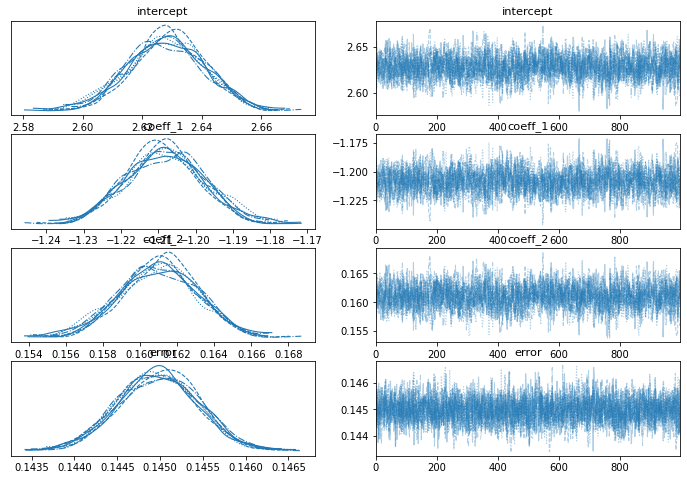

In [0]:
# Posterior analysis
with regression_model:
    az.plot_trace(trace_regression);

In [0]:
# posterior statistics
with regression_model:
    display(az.summary(trace_regression, round_to=2))

mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
2.63,0.01,2.6,2.65,0.0,0.0,1446.59,1874.65,1.0
-1.21,0.01,-1.23,-1.19,0.0,0.0,1419.3,1670.14,1.0
0.16,0.0,0.16,0.17,0.0,0.0,1480.99,1958.74,1.0
0.14,0.0,0.14,0.15,0.0,0.0,3246.8,3441.86,1.0


In [0]:
az.hdi(trace_regression,var_names=["intercept"], hdi_prob = 0.95).values()


Out[29]: ValuesView(<xarray.Dataset>
Dimensions:    (hdi: 2)
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    intercept  (hdi) float64 2.603 2.653)

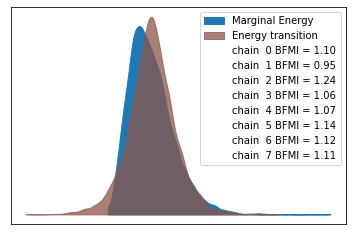

In [0]:
az.plot_energy(trace_regression);


In [0]:
# summarize results
az.summary(trace_regression)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.628,0.013,2.604,2.651,0.0,0.0,1447.0,1875.0,1.0
coeff_1,-1.208,0.010,-1.228,-1.189,0.0,0.0,1419.0,1670.0,1.0
coeff_2,0.161,0.002,0.157,0.165,0.0,0.0,1481.0,1959.0,1.0
error,0.145,0.000,0.144,0.146,0.0,0.0,3247.0,3442.0,1.0


In [0]:
# hdi bounds
intercept_bf = az.summary(trace_regression)["mean"]["intercept"], az.summary(trace_regression)["hdi_3%"]["intercept"], az.summary(trace_regression)["hdi_97%"]["intercept"]
coeff_1_bf = az.summary(trace_regression)["mean"]["coeff_1"], az.summary(trace_regression)["hdi_3%"]["coeff_1"], az.summary(trace_regression)["hdi_97%"]["coeff_1"]
coeff_2_bf = az.summary(trace_regression)["mean"]["coeff_2"], az.summary(trace_regression)["hdi_3%"]["coeff_2"], az.summary(trace_regression)["hdi_97%"]["coeff_2"]
print(intercept_bf, coeff_1_bf, coeff_2_bf)


(2.628, 2.604, 2.651) (-1.208, -1.228, -1.189) (0.161, 0.157, 0.165)


In [0]:
# Define quadratic function
def quad_func(alpha, beta_1, beta_2, x):
    return alpha + beta_1 * x + beta_2 * x**2

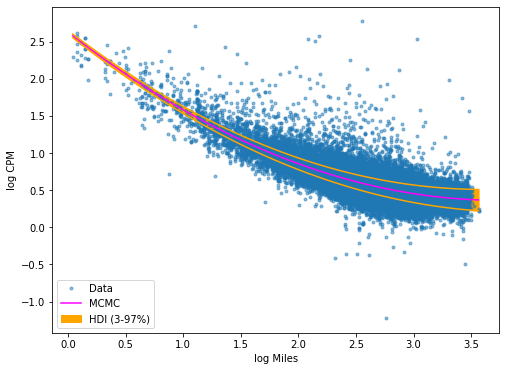

In [0]:
# Plot the original data and the fitted line
plt.figure(figsize=(8,6))
plt.plot(x_data, y_data, '.', alpha=0.5, label='Data')
plt.plot(x_fit, quad_func(intercept_bf[0], coeff_1_bf[0], coeff_2_bf[0], x_fit) , color='magenta', label='MCMC')
plt.plot(x_fit, quad_func(intercept_bf[1], coeff_1_bf[1], coeff_2_bf[1], x_fit) , '-', color="orange")
plt.plot(x_fit, quad_func(intercept_bf[2], coeff_1_bf[2], coeff_2_bf[2], x_fit) , '-', color="orange")
plt.fill_between(x_fit, quad_func(intercept_bf[1], coeff_1_bf[1], coeff_2_bf[1], x_fit), quad_func(intercept_bf[2], coeff_1_bf[2], coeff_2_bf[2], x_fit), color='orange', alpha=1, label='HDI (3-97%)')
plt.xlabel('log Miles')
plt.ylabel('log CPM')
plt.legend()
plt.show()


## Using EMCEE

In [0]:
!pip install emcee

     |████████████████████████████████| 46 kB 4.0 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-324e3bde-575d-429c-a793-1671c7d651b4/bin/python -m pip install --upgrade pip' command.


In [0]:
# data
x = df["log Miles"].values
y = df["log CPM"].values
yerr = 0.434 * 0.1 # log_unc = 0.434 * uncn/n
yerr = 0.3


In [0]:
# set initial parameters
alpha0 = 2.7
beta0_1 = -1.2
beta0_2 = 0.16

p0 = [alpha0, beta0_1, beta0_2]
print("Initial params",p0)


Initial params [2.7, -1.2, 0.16]


In [0]:
# Define quadratic function
def model_quadratic(theta, x):
    alpha, beta_1, beta_2 = theta
    return alpha + beta_1 * x + beta_2 * x**2

In [0]:
def log_likelihood(theta, x, y, yerr):
    alpha, beta_1, beta_2 = theta
    model = model_quadratic(theta, x)
    sigma2 = yerr ** 2 #+ model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [0]:
# max likelihood solution
from scipy.optimize import minimize

np.random.seed(8527)
nll = lambda *args: -log_likelihood(*args)
# initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
initial = np.array(p0)# + 0.1 * np.random.randn(len(p0))
soln = minimize(nll, initial, args=(x, y, yerr))
#m_ml, b_ml, log_f_ml = soln.x
alpha_ml, beta_1_ml, beta_2_ml = soln.x

print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml))
print("beta_1 = {0:.3f}".format(beta_1_ml))
print("beta_2 = {0:.3f}".format(beta_2_ml))


Maximum likelihood estimates:
alpha = 2.629
beta_1 = -1.209
beta_2 = 0.161


In [0]:
# simple prior: uniform prior definition with range cutoffs.
def log_prior(theta):
    alpha, beta_1, beta_2 = theta
    if alpha0-1 < alpha < alpha0+1 and beta0_1-1. < beta_1 < beta0_1+1. and beta0_2-1 < beta_2 < beta0_2+1:
        return 0.0
    return -np.inf

# log prob is sum of log prior and log likelihood
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [0]:
# sample the posterior distro around the max likelihood with emcee
import emcee

pos = initial + 1e-4 * np.random.randn(32, len(initial))
print("Using Initial Guess params.")
nwalkers, ndim = pos.shape

#from multiprocessing import Pool
#with Pool() as pool:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr),
    moves=[
    (emcee.moves.DEMove(), 0.5),
    (emcee.moves.DESnookerMove(), 0.5),
    ]#, pool=pool
)
sampler.run_mcmc(pos, 25000, progress=False);

af = sampler.acceptance_fraction
print("Mean acceptance fraction:", np.mean(af))

Using Initial Guess params.
Mean acceptance fraction: 0.63348


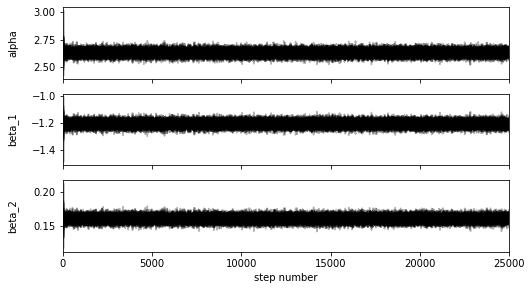

(7680, 3)


In [0]:
    # Check posterior distribution on final set of samples
    
    fig, axes = plt.subplots(ndim, figsize=(8, 1.5*ndim), sharex=True)
    samples = sampler.get_chain()
    labels = ["alpha", "beta_1", "beta_2"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    plt.show()
    
    # estimate the chain's integrated autocorrelation time
    #tau = sampler.get_autocorr_time()
    #print(tau)
    
    # suggested discarding first few tau and thinning by about half tau
    # tau needs to be scalar, and finite.  it's neither right now...  switch to consts for debugging
    #flat_samples = sampler.get_chain(discard=np.round(tau*2.5), thin=np.round(tau/2.5), flat=True)
    flat_samples = sampler.get_chain(discard=1000, thin=100, flat=True)
    print(flat_samples.shape)

In [0]:
# !pip install corner

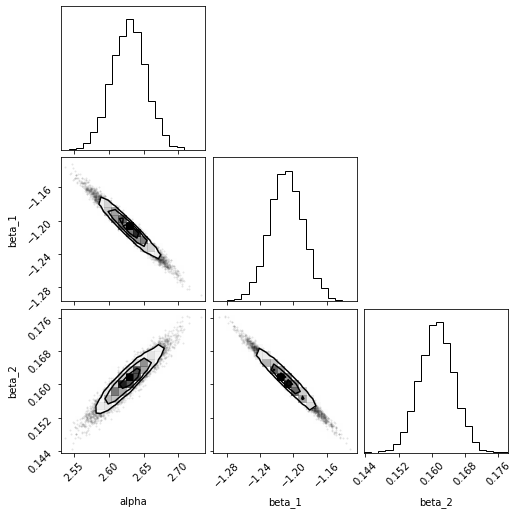

In [0]:
import corner

fig = corner.corner(
    flat_samples, labels=labels #, truths=[m_true, b_true, np.log(f_true)]
);

In [0]:
from IPython.display import display, Math

results=[]
params=[]
params_low, params_high = [], []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [.3, 50, 99.7])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    results.append([mcmc[0], mcmc[1], mcmc[2]])
    params.append(mcmc[1])
    params_low.append(mcmc[0])
    params_high.append(mcmc[2])



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [0]:
params_low, params, params_high

Out[188]: ([2.558443617452462, -1.266770558723382, 0.1494202602227432],
 [2.6287862829423085, -1.2088651961347212, 0.16113662456528435],
 [2.6995267043123428, -1.1510998655671771, 0.17301790038890894])

In [0]:
# Calculate reduced chi-square
y_chi = model_quadratic(params,x)

chi2 = sum(((y_chi - y)/yerr)**2)
dof = len(y) - len(p0)
rchi2A = chi2 / dof
rchi2 = "%s" % float("%.2g" % rchi2A)
print("reduced chisq = ", rchi2)


reduced chisq =  0.23


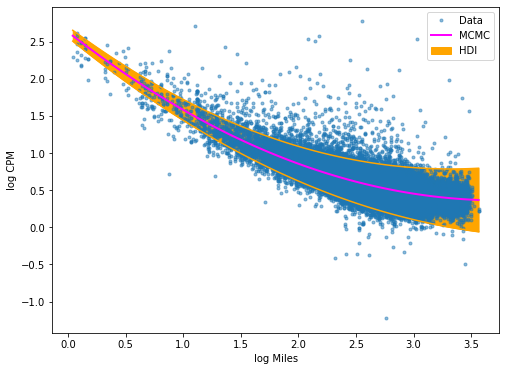

In [0]:
# Plot the original data and the fitted line
plt.figure(figsize=(8,6))
plt.plot(x_data, y_data, '.', alpha=0.5, label='Data')
plt.plot(x_fit, model_quadratic(params,x_fit), color='magenta', linewidth=2., label="MCMC")
plt.plot(x_fit, model_quadratic(params_low,x_fit), '-', color="orange")
plt.plot(x_fit, model_quadratic(params_high,x_fit), '-', color="orange")
plt.fill_between(x_fit, model_quadratic(params_low,x_fit), model_quadratic(params_high,x_fit), color='orange', alpha=1, label='HDI')
plt.xlabel('log Miles')
plt.ylabel('log CPM')
plt.legend()
plt.show()


### Hierarchical Bayesian Inference


In [0]:

import numpy as np
import pandas as pd
import emcee

# Generate example data
np.random.seed(0)
n_locations = 3
n_samples_per_location = 20
locations = np.repeat(np.arange(n_locations), n_samples_per_location)
xdata = np.random.rand(n_locations * n_samples_per_location) * 10
true_slopes = np.random.rand(n_locations) * 2
true_intercepts = np.random.rand(n_locations) * 3
ydata = true_slopes[locations] * xdata + true_intercepts[locations] + np.random.randn(n_locations * n_samples_per_location)

# Create a DataFrame
df = pd.DataFrame({'Location': locations, 'xdata': xdata, 'ydata': ydata})

# Define the hierarchical Bayesian model
def linear_model(params, x):
    slope, intercept = params
    return slope * x + intercept

def log_likelihood(params, x, y):
    y_model = linear_model(params, x)
    return -0.5 * np.sum((y - y_model)**2)

def log_prior(params):
    slope, intercept = params
    prior_slope = np.log(1.0 / (1 + slope**2))  # Cauchy prior on slope
    prior_intercept = np.log(1.0 / (1 + intercept**2))  # Cauchy prior on intercept
    return prior_slope + prior_intercept

def log_posterior(params, x, y):
    return log_prior(params) + log_likelihood(params, x, y)

# Run the hierarchical Bayesian inference using emcee
n_walkers = 50
n_steps = 500
initial_guesses = np.random.randn(n_walkers, 2)  # Initial parameter guesses for each walker
sampler = emcee.EnsembleSampler(n_walkers, 2, log_posterior, args=(df['xdata'], df['ydata']))
sampler.run_mcmc(initial_guesses, n_steps, progress=True)

# Extract the samples from the sampler
samples = sampler.get_chain(discard=100, flat=True)
